# Notebook 01: Plot imagery from Cambodia Cube

metadata blah

## Import libraries and create functions

In [1]:
from datacube import Datacube
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import xarray as xr
from datacube_stats.statistics import GeoMedian
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian


In [220]:
#Define function to load data for each sensor
def DCLoadFunction(cloud_free_threshold):
    for sensor in sensors:
        sensor_nbar = cdc.load(product= sensor+'_usgs_sr_scene',
                               measurements = bands_of_interest,group_by='solar_day', **query)

        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine

        sensor_pq= sensor_nbar.pixel_qa
        quality_mask = masking.make_mask(sensor_pq, **mask_components)
        good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
        sensor_nbar2 = sensor_nbar.where(good_data)

        cloud_free = masking.make_mask(sensor_pq,
                                       cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
        mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
                                                                   how='all')

        sensor_clean[sensor] = mostly_good

        print('loaded %s' % sensor) 
    print('complete')
    
    
    nbar_clean = xr.concat(sensor_clean.values(), 'time')
    nbar_clean = nbar_clean.sortby('time')
    nbar_clean.attrs['crs'] = crs
    nbar_clean.attrs['affin|e'] = affine
    return crs, affine,nbar_clean

def three_band_image_subplots(ds, bands, num_cols, figsize = [10,50], left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, 
    and plots them on the RGB bands of an image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    fig = plt.figure(figsize = figsize)
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
    try:
        for i, ax in enumerate(fig.axes):
            rgb = ds.isel(time =i).to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
            rgb=rgb.where(rgb>=0)
            fake_saturation = 6000.0
            rgb = rgb.astype('double')
            clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
            max_val = clipped_visible.max(['y', 'x'])
            scaled = (clipped_visible / max_val) 
            ax.imshow(scaled, interpolation = 'nearest')
    except IndexError:
        # This error will pop up if there are not enough scenes to fill the number of 
        # rows x columns, so we can safely ignore it
        fig.delaxes(ax)
        plt.draw() 


def three_band_image(ds, bands,figsize = [10,10]):
    rgb = ds.to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
    fake_saturation = 6000.0
    rgb = rgb.astype('double')
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    print(type(clipped_visible))
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    
    fig = plt.figure(figsize = figsize)
    plt.imshow(scaled)


In [235]:
#Temporal range, wavelengths/band and sensors of interest are defined

#Coordinates for area of interest
lat_min = 13.000 #down
lat_max = 13.100 #up
lon_min = 103.300 #left
lon_max = 103.400 #right

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.20

#temporal range is defined
start_of_epoch = '2015-01-01'
end_of_epoch =  '2016-05-01'

#wavelengths/bands of interest are defined
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'pixel_qa',
                     #'swir2',
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8',]
#        'ls7',] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2015-01-01', '2016-05-01'), 'x': (103.3, 103.4), 'y': (13.1, 13.0), 'crs': 'EPSG:4326'}


In [241]:
output_folder= '/g/data/u46/users/ext547/ewater/output_data/image_dump/'

In [236]:
mask_components = {'cloud_shadow': 'no_cloud_shadow',
                   'cloud': 'no_cloud',}

In [237]:
sensor_clean = {}
crs,affine,nbar_clean=DCLoadFunction(cloud_free_threshold)

loaded ls8
complete


<Figure size 720x3600 with 0 Axes>

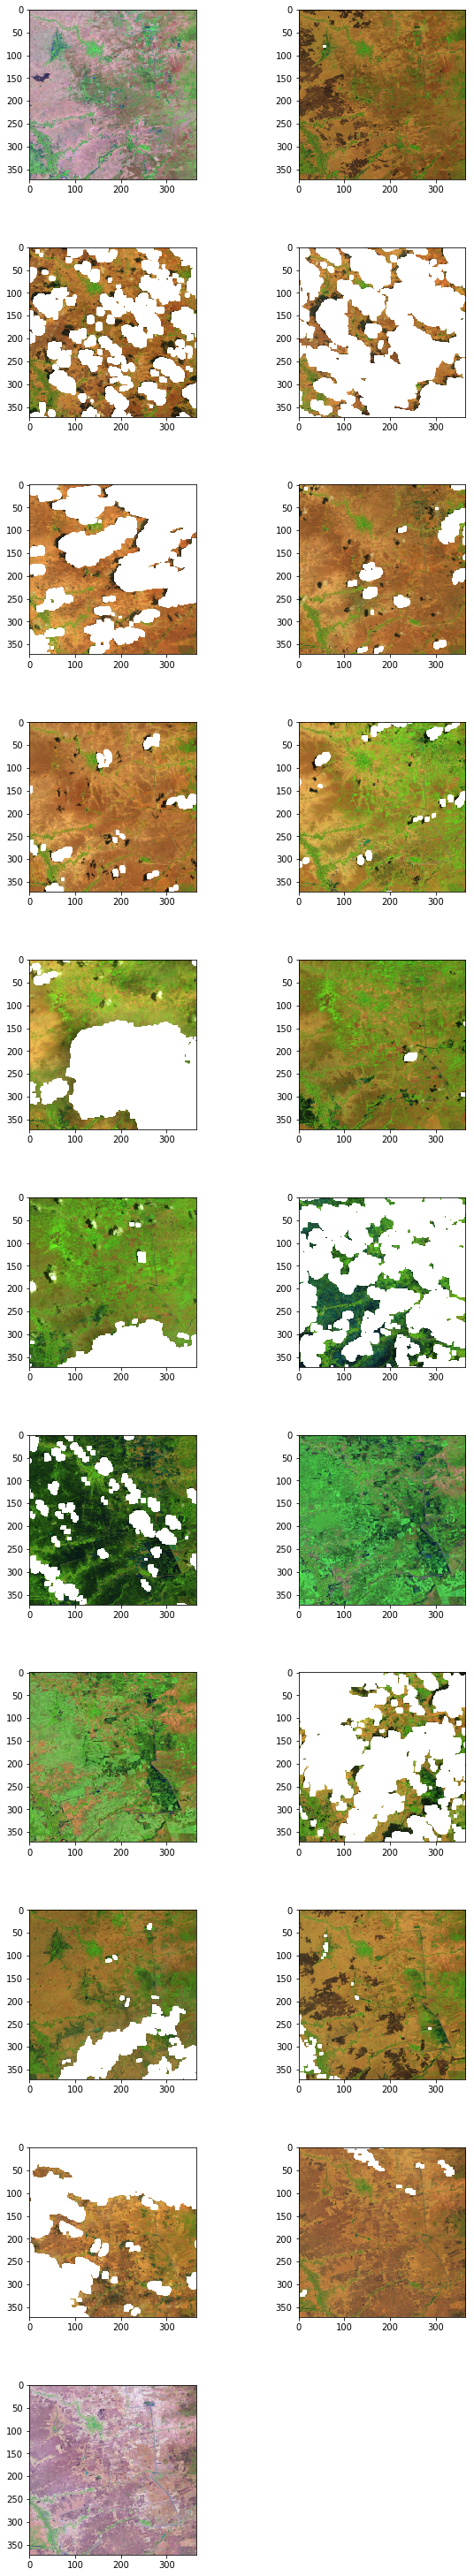

In [238]:
three_band_image_subplots(nbar_clean, ['swir1','nir', 'green'], 2)

In [239]:
#geomedian transform
nbar_gm=GeoMedian().compute(nbar_clean)

<class 'xarray.core.dataarray.DataArray'>


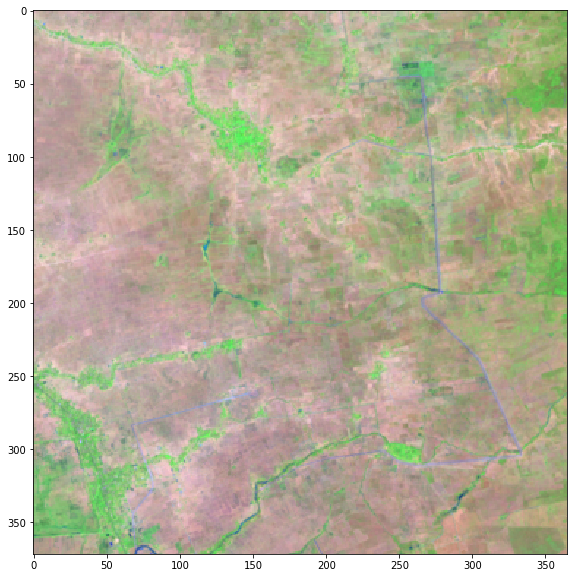

In [252]:
three_band_image(nbar_gm,['swir1','nir', 'green'])
plt.savefig('{0}NB01_1_geomedian.jpg'.format(str(output_folder))) #Save figure

In [ ]:
# gm_ndvi=